# Convolutional Neural Network Model for Land Classification

### Importing Necessary Libraries

In [1]:
# Suppress warnings from libraries to keep the output clean
import warnings
warnings.filterwarnings('ignore')

# Import standard Python libraries
import os  # For operating system dependent functionality
import shutil  # For file operations like copying and removing files
import itertools  # For advanced iteration operations
import random  # For generating random numbers

# Import scientific computing libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations

# Import libraries for plotting and visualization
import matplotlib.pyplot as plt  # For creating static, animated, and interactive visualizations
import matplotlib.image as mpimg  # For reading image files

# Import TensorFlow, a deep learning library
import tensorflow as tf

# Import Keras, a high-level API for building and training deep learning models
import tensorflow.keras
from tensorflow.keras import models
from tensorflow.keras import backend as K  # For accessing the Keras backend
from tensorflow.keras.applications import imagenet_utils  # Utilities for ImageNet data
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For real-time data augmentation
from tensorflow.keras.preprocessing import image  # For image preprocessing utilities
from tensorflow.keras.metrics import categorical_crossentropy  # Loss function for multi-class classification
from tensorflow.keras.optimizers import Adam  # Optimizer for training models
from tensorflow.keras.models import Sequential, Model, load_model  # For creating and loading models

# Import various Keras layers for building neural networks
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D
from tensorflow.keras.layers import Activation, Dense, Flatten, Input, MaxPooling2D, Dropout

# Import scikit-learn and SciPy libraries
from sklearn.metrics import confusion_matrix  # For computing confusion matrix
from scipy import misc, ndimage  # For image processing

# Import for plotting model architecture
from tensorflow.keras.utils import plot_model  # For creating a visual representation of the model

# Enable inline plotting in Jupyter notebooks
%matplotlib inline

### Setting Up A Reproducible Environment

In [2]:
# Restore np.random.seed to its original state
np.random.seed = np.random.seed

# Ensure np.random.seed is not reassigned
assert isinstance(np.random.seed, type(np.random.RandomState().seed)), "np.random.seed has been reassigned."

# Set up a reproducible environment
# Setting a specific hash seed for Python's hash-based operations
os.environ['PYTHONHASHSEED'] = '0'
# Setting the seed for NumPy's random number generator
np.random.seed(123)
# Setting the seed for Python's random module
random.seed(456)
# Setting the seed for TensorFlow's random number generator
tf.random.set_seed(789)

# Configure TensorFlow session to use a single thread for operations
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

### Setting the Paths

In [3]:
# Set the path to the main dataset and the path to the train, valid and test folders within the dataset_splits folder
base_path = 'C:/Users/isaac/datasets/eurosat-dataset'
dataset_path = 'C:/Users/isaac/datasets'
train_path = os.path.join(base_path, 'dataset_splits/train')
valid_path = os.path.join(base_path, 'dataset_splits/valid')
test_path = os.path.join(base_path, 'dataset_splits/test')

### Storing the Categories

In [4]:
# Initialize an empty list to store category names
categories = []

# Walk through the directory tree starting from the specified path
for dirpath, dirnames, filenames in os.walk(base_path):
    # Filter out 'dataset_splits' directory from the list of dirnames
    # This will modify dirnames in-place and prevent os.walk from visiting this directory
    dirnames[:] = [d for d in dirnames if d != 'dataset_splits']
    
    # Add the remaining directory names (categories) to the categories list
    categories.extend(dirnames)

# Print the list of categories (subdirectory names)
print(categories)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


### Counting Images in Train, Validation, and Test Sets

In [5]:
# Iterate through each category within the categories list 
for category in categories:
    # Construct the path to the training images directory for the current category
    tr = os.path.join(train_path, category)
    # Get the number of training images in the current category
    len_tr = len(os.listdir(tr))

    # Construct the path to the validation images directory for the current category
    val = os.path.join(valid_path, category)
    # Get the number of validation images in the current category
    len_val = len(os.listdir(val))

    # Construct the path to the test images directory for the current category
    test = os.path.join(test_path, category)
    # Get the number of test images in the current category
    len_test = len(os.listdir(test))

    # Printing the category names and the training, validation and test images for each category
    print(category + ":")
    print('Train images for ' + category + ': {}'.format(len_tr))
    print('Validation images for ' + category + ': {}'.format(len_val))
    print('Test images for ' + category + ': {}'.format(len_test))
    print('')

AnnualCrop:
Train images for AnnualCrop: 1200
Validation images for AnnualCrop: 150
Test images for AnnualCrop: 150

Forest:
Train images for Forest: 1200
Validation images for Forest: 150
Test images for Forest: 150

HerbaceousVegetation:
Train images for HerbaceousVegetation: 1200
Validation images for HerbaceousVegetation: 150
Test images for HerbaceousVegetation: 150

Highway:
Train images for Highway: 1000
Validation images for Highway: 125
Test images for Highway: 125

Industrial:
Train images for Industrial: 1000
Validation images for Industrial: 125
Test images for Industrial: 125

Pasture:
Train images for Pasture: 800
Validation images for Pasture: 100
Test images for Pasture: 100

PermanentCrop:
Train images for PermanentCrop: 1000
Validation images for PermanentCrop: 125
Test images for PermanentCrop: 125

Residential:
Train images for Residential: 1200
Validation images for Residential: 150
Test images for Residential: 150

River:
Train images for River: 1000
Validation im

### Creating Data Generators for Train, Validation, and Test Sets

In [6]:
# Create a data generator for the training dataset
# This generator will load and preprocess images from the 'train_path' directory
train_batches = ImageDataGenerator().flow_from_directory(
    train_path,
    target_size=(64, 64),
    classes=categories,
    batch_size=32
)
# Create a data generator for the validation dataset
# This generator will load and preprocess images from the 'valid_path' directory
valid_batches = ImageDataGenerator().flow_from_directory(
    valid_path,
    target_size=(64, 64),
    classes=categories,
    batch_size=16
)
# Create a data generator for the test dataset
# This generator will load and preprocess images from the 'test_path' directory
test_batches = ImageDataGenerator().flow_from_directory(
    test_path,
    target_size=(64, 64),
    classes=categories,
    batch_size=16,
    shuffle=False)

Found 10800 images belonging to 10 classes.
Found 1350 images belonging to 10 classes.
Found 1350 images belonging to 10 classes.


### Defining and Demonstrating Image Plotting Function

In [8]:
# Function to plot images with labels
def plots(ims, figsize=(30, 15), rows=1, interp=False, titles=None):
    # Check if the input is a list of numpy arrays
    if isinstance(ims[0], np.ndarray):
        # Convert to uint8 type for image display
        ims = np.array(ims).astype(np.uint8)
        # Ensure the images have the correct shape for display
        if ims.shape[-1] != 3:  # Check if the last dimension is not 3 (RGB channels)
            ims = ims.transpose((0, 2, 3, 1))  # Rearrange dimensions to (N, H, W, C)

    # Create a new figure with the specified size
    f, axes = plt.subplots(rows, len(ims) // rows + (len(ims) % rows != 0), figsize=figsize)
    
    # Flatten axes array if there are multiple rows
    if rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Iterate through images and plot them
    for i, ax in enumerate(axes):
        if i < len(ims):
            ax.axis('Off')  # Turn off axis lines and labels
            if titles is not None and i < len(titles):
                ax.set_title(titles[i], fontsize=16)  # Set title if provided
            ax.imshow(ims[i], interpolation='none' if not interp else 'bilinear')  # Display image
        else:
            ax.axis('Off')  # Hide any extra subplots
    
    plt.tight_layout()  # Adjust subplot params so that the subplot(s) fits in to the figure area
    plt.show()  # Display the figure

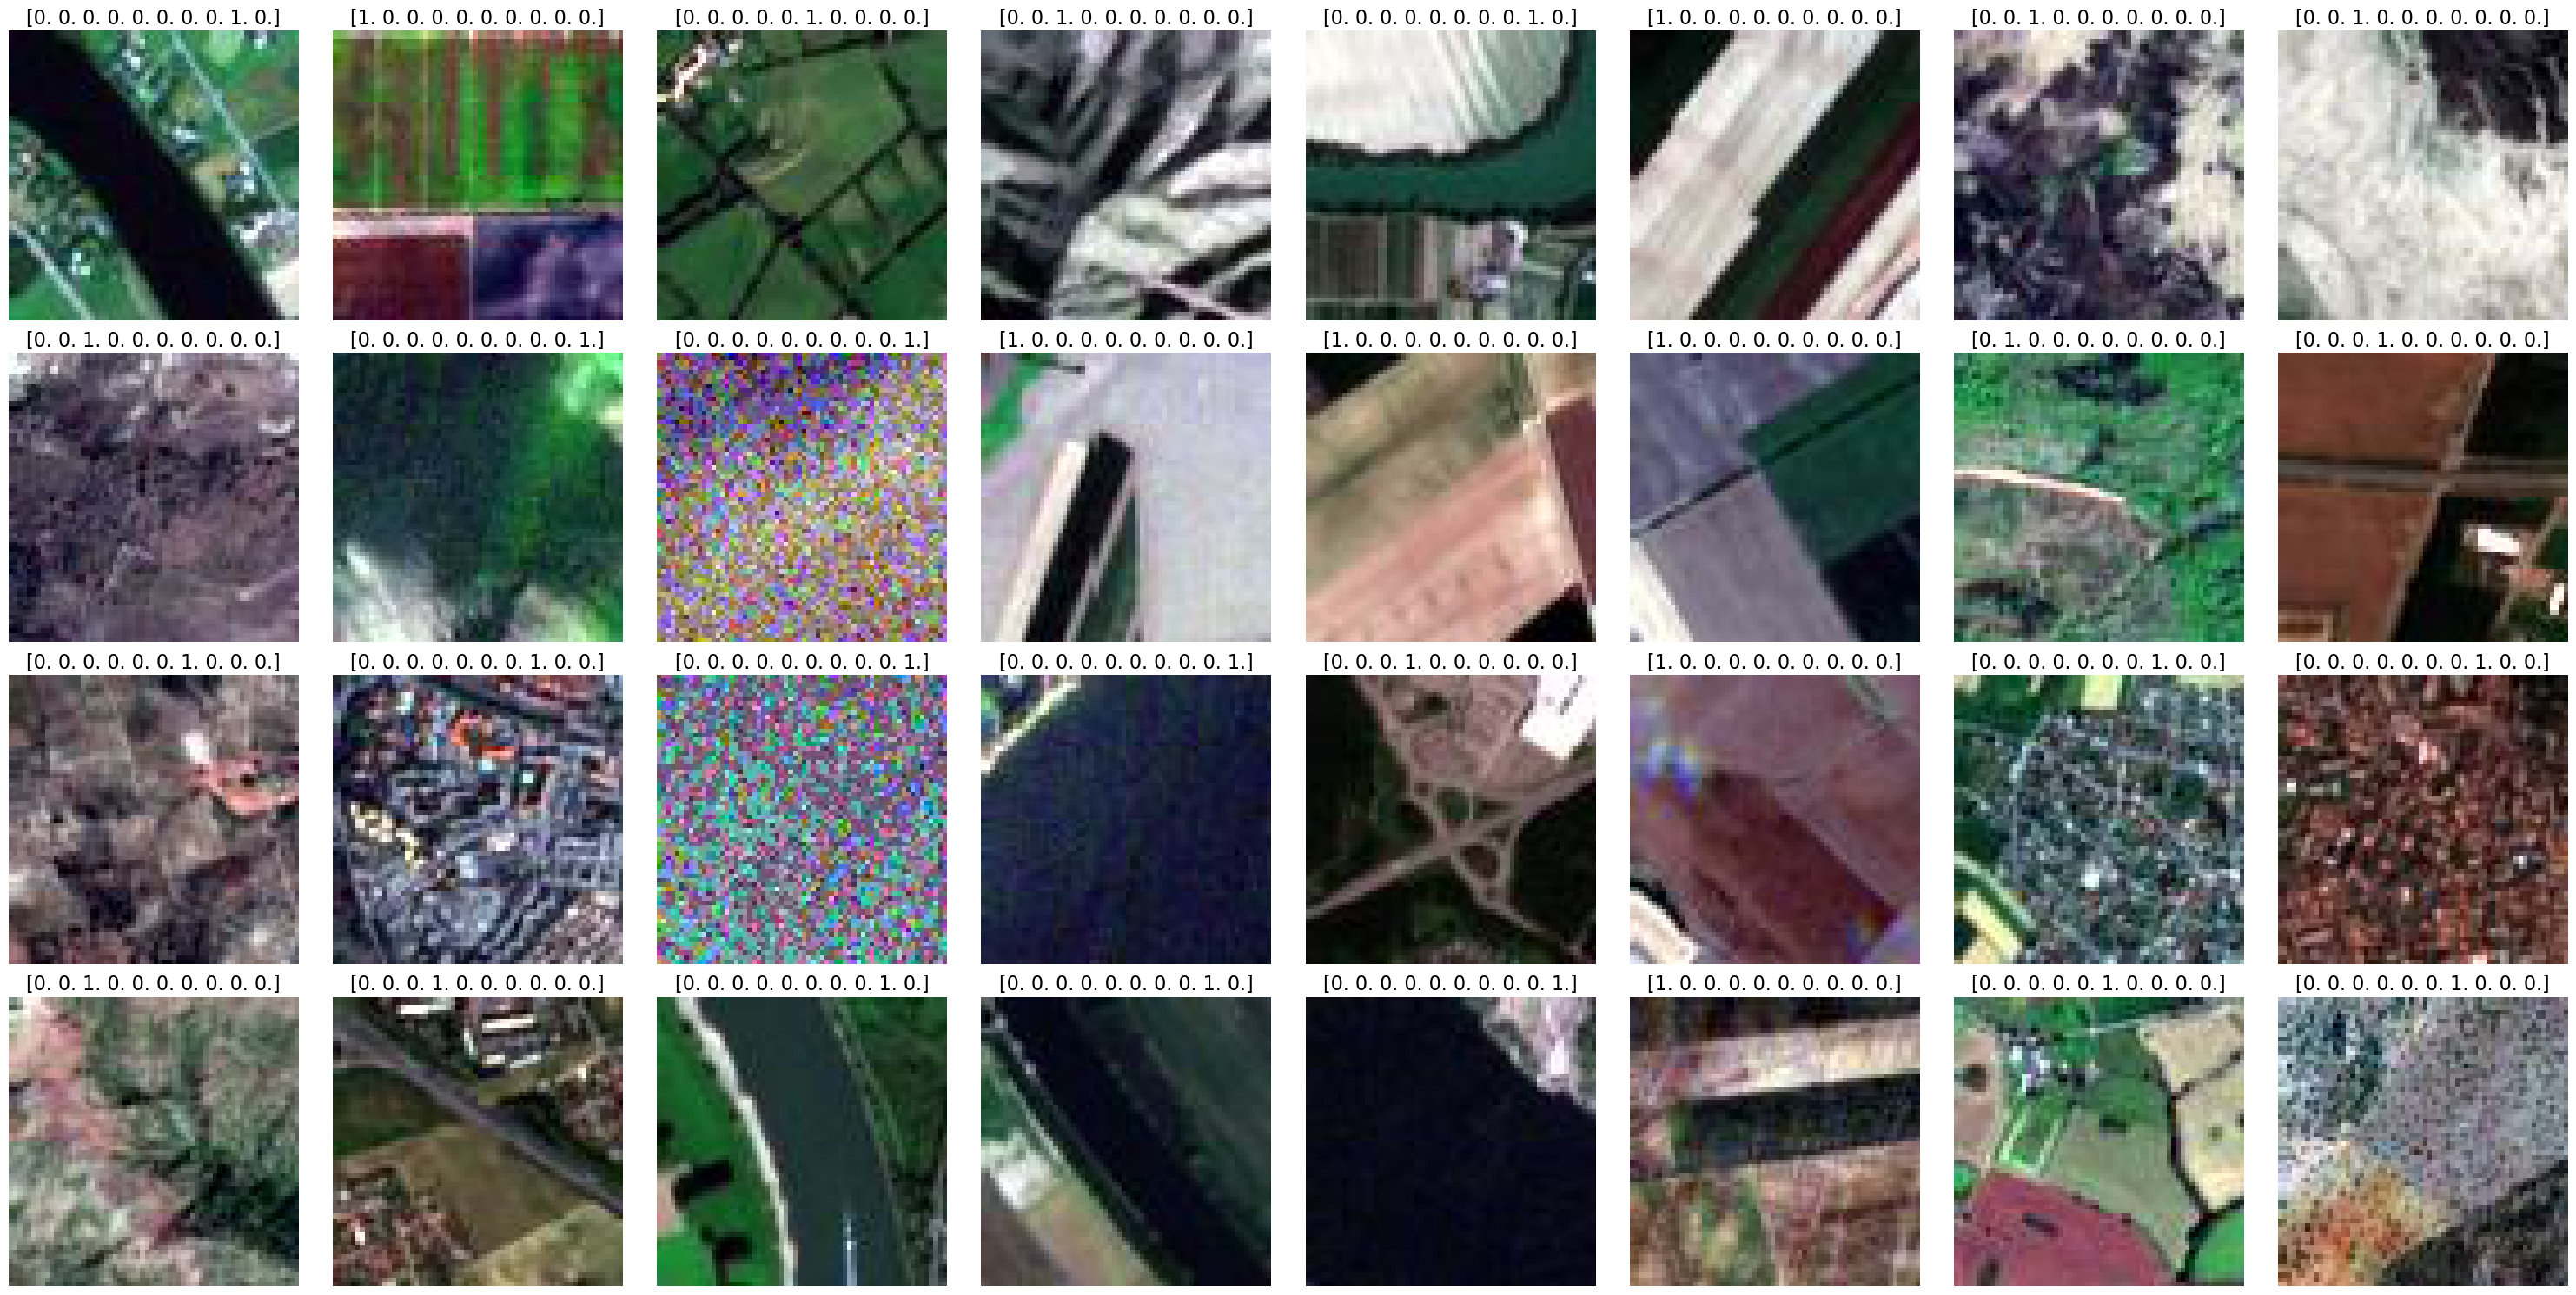

In [9]:
# Example usage with a batch of images and labels
imgs, labels = next(train_batches)  # Get a batch of images and labels from the data generator
plots(imgs, rows=4, titles=labels)  # Plot the images with titles

# CNN Training and Building
### Defining and Compiling a Simple Convolutional Neural Network (CNN) Model

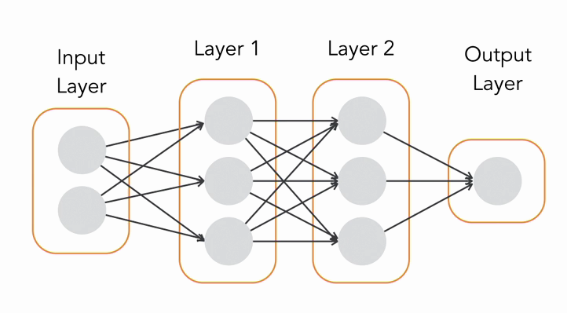

In [10]:
# Define the model using the Sequential API
model = Sequential([
    Input(shape=(64, 64, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # Add Dropout layer to prevent overfitting
    Dense(10, activation='softmax')
])

# Compile the model
# Use the Adam optimizer with a learning rate of 0.0001
# Use categorical crossentropy loss function, suitable for multi-class classification
# Track accuracy as the metric to evaluate model performance
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary to see the architecture and number of parameters
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,386,986 (9.11 MB)

 Trainable params: 2,386,986 (9.11 MB)

 Non-trainable params: 0 (0.00 B)

### Plotting and Displaying the Model Architecture

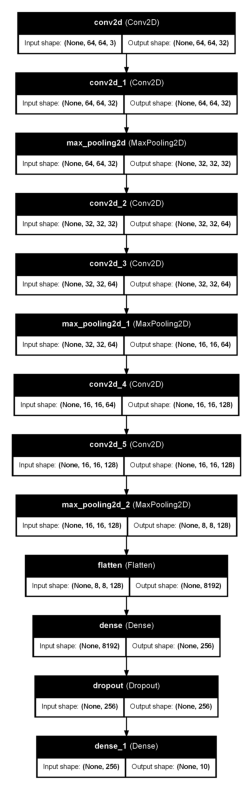

In [11]:
# Plot the model architecture
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Display the plot
img = mpimg.imread('model_plot.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

### Training the CNN Model and Measuring Training Time

In [12]:
%%time
# fits the model on data generated batch by batch by ImageDataGenerator
model.fit(
    train_batches,  # The training data generator that yields batches of training images and labels.
    steps_per_epoch=1080,  # Number of batches to be processed per epoch. This is the total number of training examples divided by the batch size.
    validation_data=valid_batches,  # The validation data generator that yields batches of validation images and labels.
    validation_steps=270,  # Number of batches to be processed for validation. This is the total number of validation examples divided by the batch size.
    epochs=5,  # The number of times the entire training dataset is passed through the model during training.
    verbose=2  # The verbosity mode of the training process. `verbose=2` means it will print one line per epoch with the progress and metrics.
)

Epoch 1/5
1080/1080 - 111s - 103ms/step - accuracy: 0.3419 - loss: 2.0101 - val_accuracy: 0.5837 - val_loss: 1.2220
Epoch 2/5
1080/1080 - 106s - 98ms/step - accuracy: 0.5360 - loss: 1.3285 - val_accuracy: 0.6541 - val_loss: 1.0310
Epoch 3/5
1080/1080 - 103s - 95ms/step - accuracy: 0.6227 - loss: 1.0975 - val_accuracy: 0.6185 - val_loss: 1.0825
Epoch 4/5
1080/1080 - 99s - 92ms/step - accuracy: 0.6735 - loss: 0.9550 - val_accuracy: 0.6911 - val_loss: 0.9151
Epoch 5/5
1080/1080 - 98s - 91ms/step - accuracy: 0.7134 - loss: 0.8451 - val_accuracy: 0.7222 - val_loss: 0.7761
CPU times: total: 3min 6s
Wall time: 8min 37s


# Prediction On Test Set

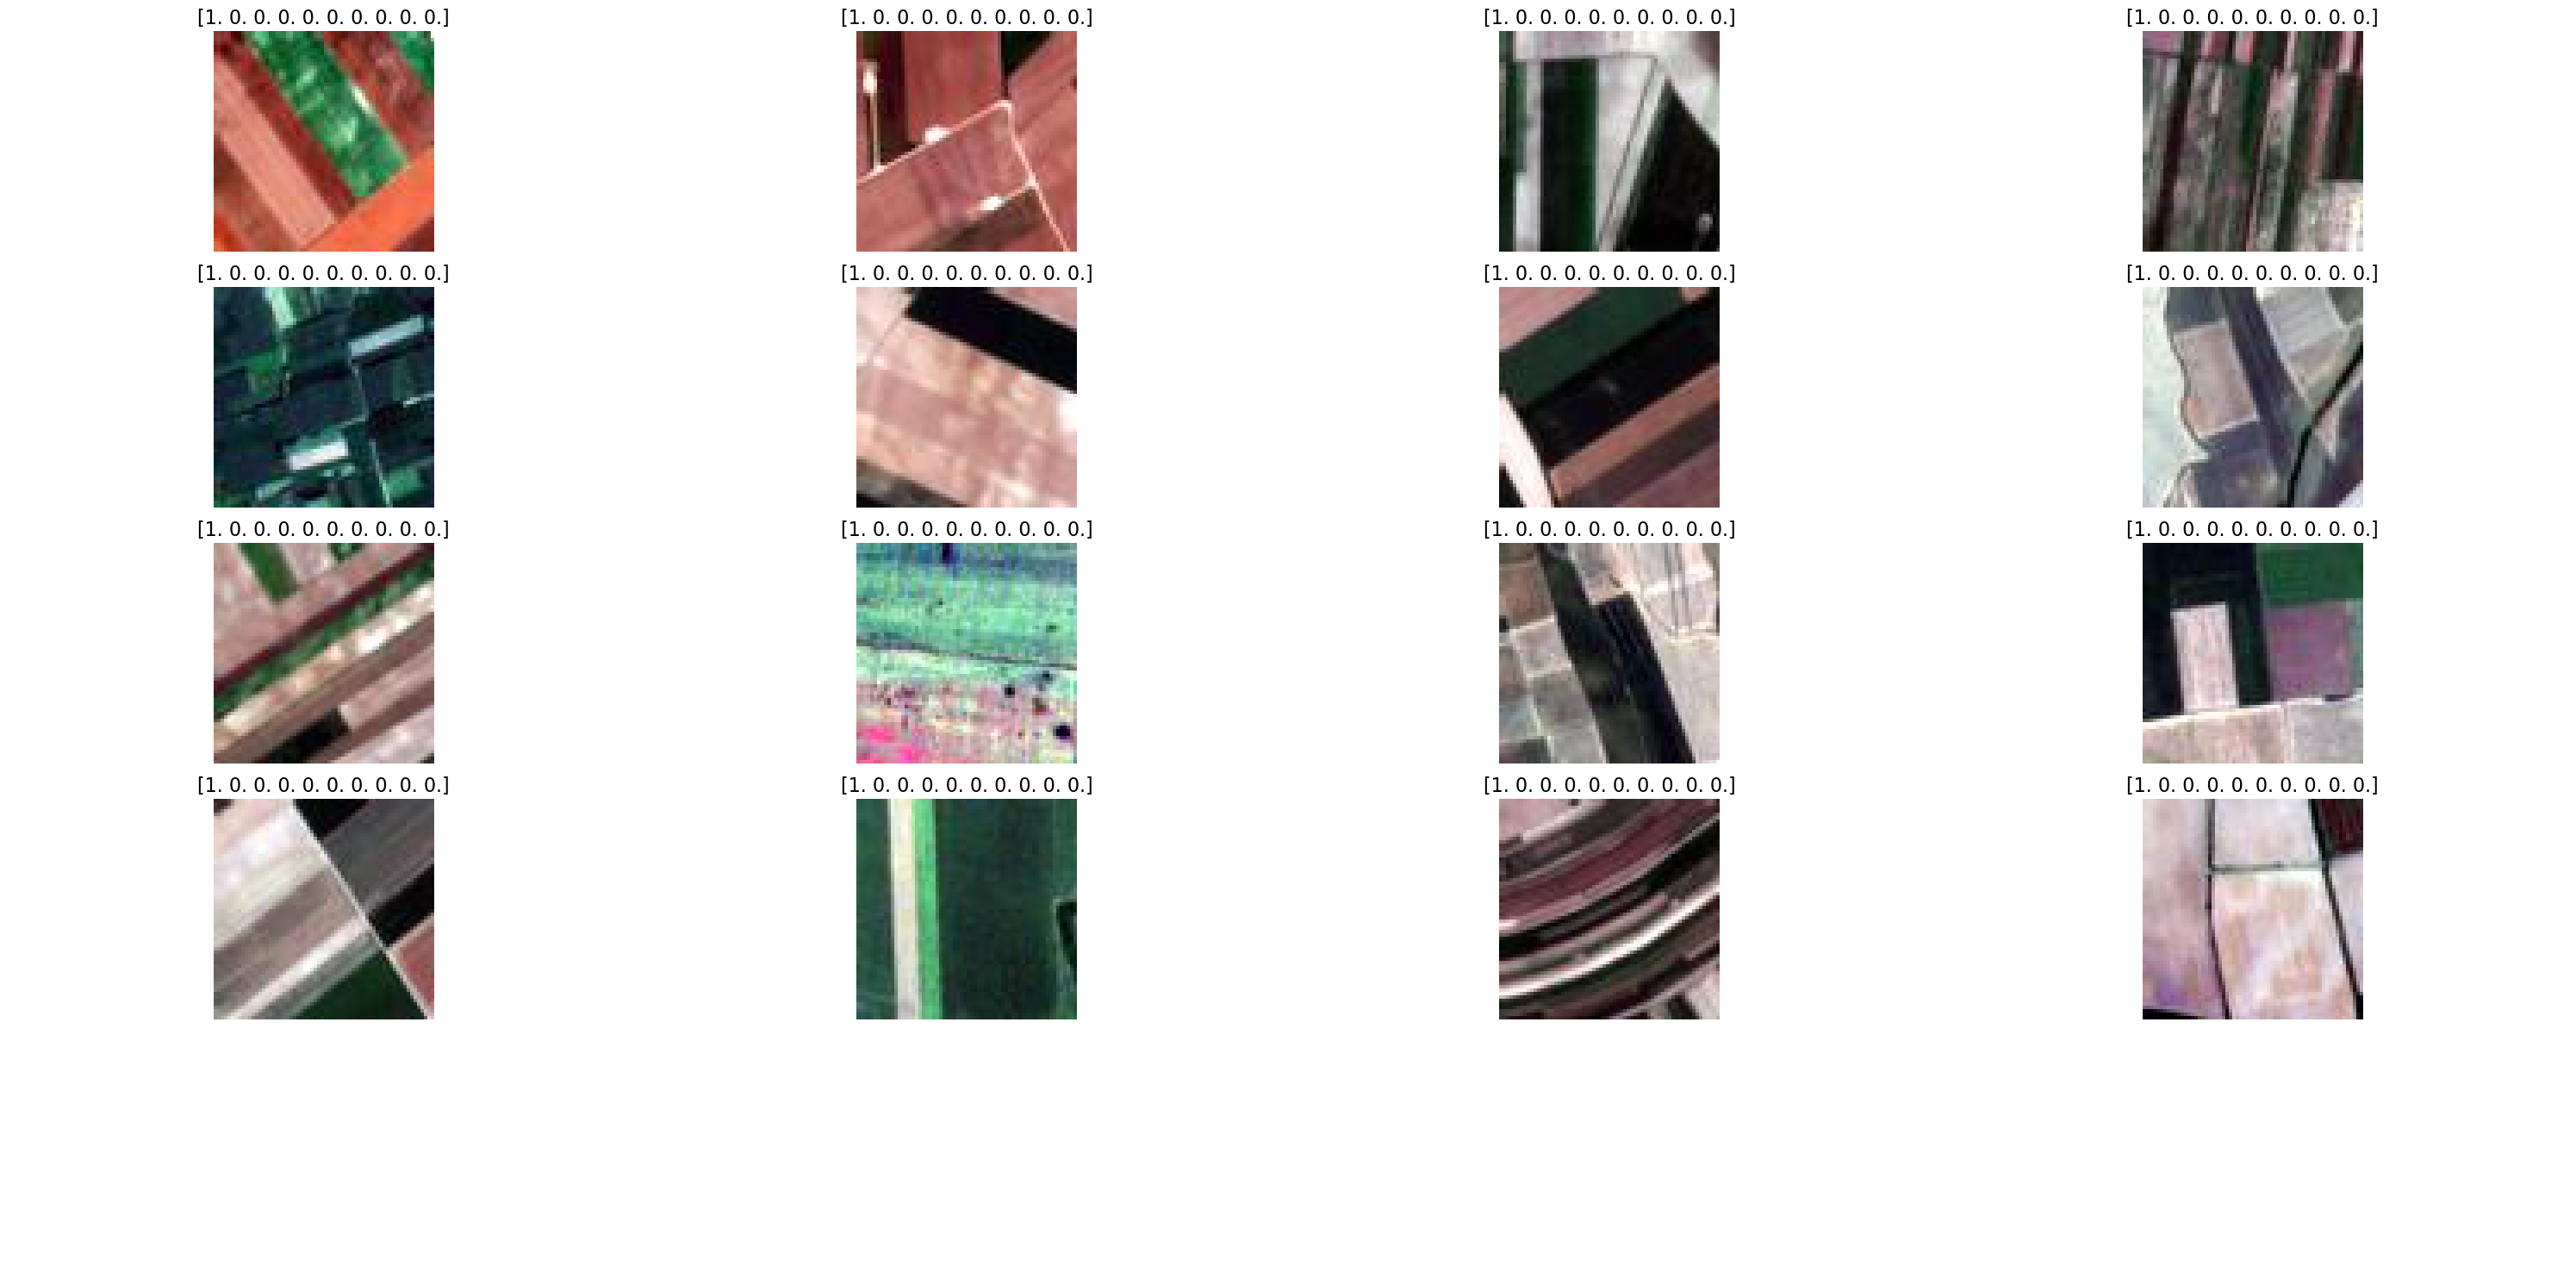

In [13]:
# Get the next batch of images and one-hot encoded labels from the test data generator
test_imgs, test_labels = next(test_batches)
# Plot the images wih the encoded labels as titles:
plots(test_imgs, rows=5, titles=test_labels)

### Retrieving and Printing Test Labels and Class Indices

In [14]:
# Get the class indices from the test_batches ImageDataGenerator
test_labels = test_batches.classes
# Print the class indices of the test images
print(test_labels)

print()

# Get the class-to-index mapping from the test_batches ImageDataGenerator
test_batches.class_indices

[0 0 0 ... 9 9 9]



{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

### Generating Predictions and Calculating Confusion Matrix


In [15]:
# Generate predictions on the test dataset using the model and the test_batches generator.
# `steps=270` indicates the number of batches to yield from the generator before stopping.
# `verbose=0` suppresses the progress messages.
predictions = model.predict(test_batches, steps=270, verbose=0)

# Calculate the confusion matrix to evaluate the accuracy of the classification.
# `test_labels` are the true labels of the test data.
# `predictions.argmax(axis=1)` finds the class with the highest predicted probability for each sample.
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

### Defining Function to Plot Confusion Matrix and Plotting It

In [16]:
# Function to plot the confusion matrix - modified from scikit-learn.org
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, text_color='black', text_size=10, font_weight='normal'):                
    # Create a new figure with the specified size
    plt.figure(figsize=(15, 8))
    # Display the confusion matrix as an image
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)  # Set the title of the plot
    plt.colorbar()  # Add a colorbar to the plot
    
    # Set the tick marks and labels for the x and y axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)  # Rotate x-axis labels 90 degrees
    plt.yticks(tick_marks, classes)
            
    # Print whether the confusion matrix is normalized
    if normalize:
        print('Normalized confusion matrix')
        cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
    else:
        print('Confusion matrix, without normalization')

    # Print the confusion matrix
    print(cm)

    # Set a threshold to determine text color based on the matrix value
    thresh = cm.max() / 2.
    
    # Iterate over the confusion matrix to add text annotations
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i,j]:.2f}' if normalize else f'{cm[i,j]}',
                 horizontalalignment="center",
                 color=text_color if cm[i, j] > thresh else "black",
                 fontsize=text_size,
                 fontweight=font_weight)
    
    # Adjust the layout to fit the plot and add labels for the axes
    plt.tight_layout()
    plt.ylabel("True label")  # Label for the y-axis
    plt.xlabel("Predicted label")  # Label for the x-axis

Confusion matrix, without normalization
[[110   2   1   6   0   7   9   0  11   4]
 [  0 136   2   0   0   1   0   6   2   3]
 [  2   4  80  11  11   3  32   5   2   0]
 [  5   2   3  65  10   2  15   0  22   1]
 [  0   0   2   4 105   0  11   3   0   0]
 [  3   7  12   4   0  60   4   0   9   1]
 [  5   0  23  16  13   1  64   1   2   0]
 [  0   3   1   1   4   0   0 141   0   0]
 [  9   1   1  16   0   1   2   0  94   1]
 [  5   4   0   0   0   3   1   0   4 133]]


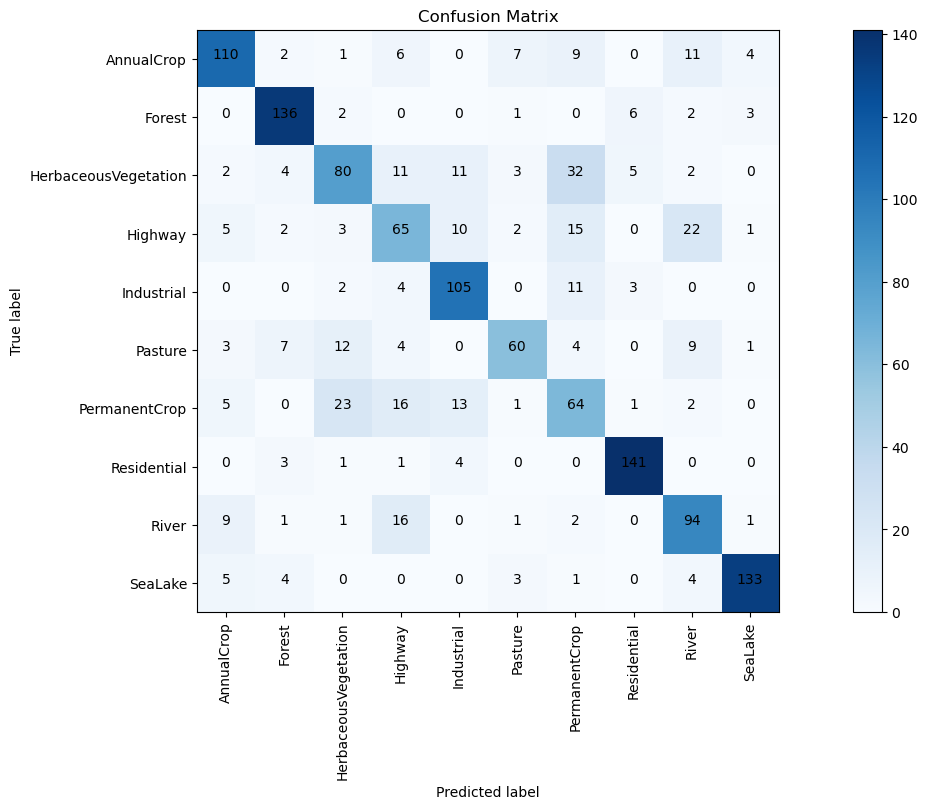

In [17]:
# Print the Confusion Matrix
plot_confusion_matrix(cm, categories, title='Confusion Matrix')

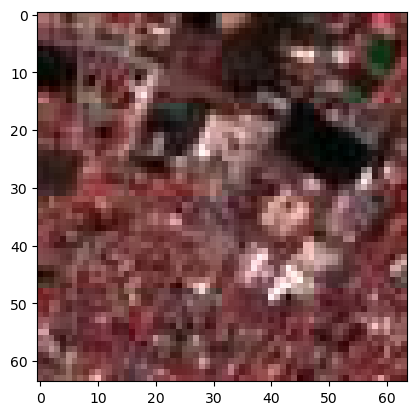

Image tensor shape: (1, 64, 64, 3)


In [18]:
# Load and preprocess the image
img_path = test_path + '/Residential/Residential_26.jpeg'
img = image.load_img(img_path, target_size=(64, 64))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

# Visualize the image
plt.imshow(img_tensor[0])
plt.show()

# Ensure the shape matches the model's input requirements
print("Image tensor shape:", img_tensor.shape) 

In [19]:
# Assuming `img` is your input image
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# Use model.predict to get probabilities for each class
predictions = model.predict(x, batch_size=10)

# Use np.argmax to get the index of the class with the highest probability
predicted_class_index = np.argmax(predictions, axis=1)[0]

print("Predicted class index is:", predicted_class_index)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Predicted class index is: 7


# Using Transfer Learning to build the CNN

### Summarising the VGG16 Model 

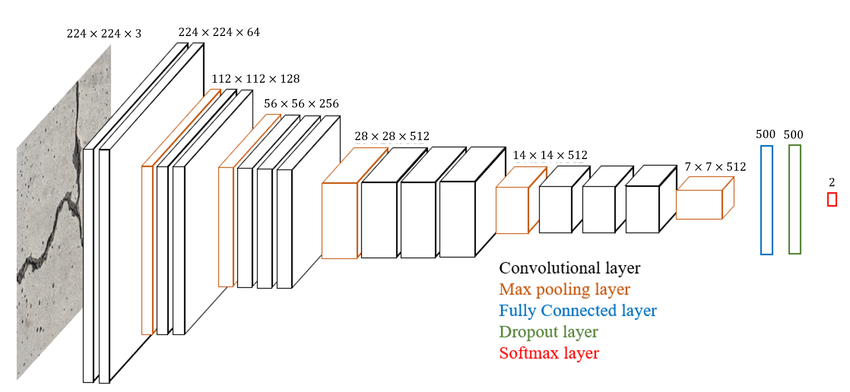

In [20]:
# Import VGG16 model from Keras applications module
vgg16_model = tensorflow.keras.applications.vgg16.VGG16(include_top=False, input_shape=(64,64,3))

# Display summary of the VGG16 model architecture
vgg16_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### Transferring the VGG16 Architecture to a Sequential Model

In [21]:
# Create a new Sequential model
model = Sequential()

# Iterate through each layer in the pre-trained VGG16 model and add it to the new model
for layer in vgg16_model.layers:
    model.add(layer)

# Display summary of the new Sequential model, which now matches the VGG16 architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### Freezing Layers for Transfer Learning and Adding Classification Layers

In [22]:
# Define the number of layers to freeze to adapt to the new dataset
NUM_TRAINABLE_LAYERS = 10

# Freeze the weights of all layers except the last NUM_TRAINABLE_LAYERS layers
for layer in model.layers[:-NUM_TRAINABLE_LAYERS]:
    layer.trainable = False  # Exclude layer from future training to retain pre-trained weights

# Add additional layers for fine-tuning and classification
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(len(categories), activation='softmax'))

# Display summary of the updated model architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,031,562 (61.16 MB)

 Trainable params: 14,886,154 (56.79 MB)

 Non-trainable params: 1,145,408 (4.37 MB)

### Training the transfer CNN model

In [23]:
# Define the optimizer with the desired learning rate
optimizer = Adam(learning_rate=0.0001)

# Compile the model using the defined optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
%%time
history = model.fit(
    train_batches,  # Data generator for the training data
    steps_per_epoch=1080,  # Number of batches to draw from `train_batches` for each epoch
    validation_data=valid_batches,  # Data generator for the validation data
    validation_steps=270,  # Number of batches to draw from `valid_batches` for validation after each epoch
    epochs=10,  # Number of times the model will go through the entire training dataset
    verbose=2  # Level of logging verbosity (2 provides one line of output per epoch with loss and accuracy)
)

Epoch 1/10
1080/1080 - 515s - 477ms/step - accuracy: 0.7932 - loss: 0.6978 - val_accuracy: 0.8785 - val_loss: 0.3907
Epoch 2/10
1080/1080 - 503s - 465ms/step - accuracy: 0.9144 - loss: 0.2798 - val_accuracy: 0.9148 - val_loss: 0.2693
Epoch 3/10
1080/1080 - 511s - 473ms/step - accuracy: 0.9403 - loss: 0.1912 - val_accuracy: 0.9341 - val_loss: 0.2329
Epoch 4/10
1080/1080 - 513s - 475ms/step - accuracy: 0.9557 - loss: 0.1410 - val_accuracy: 0.9244 - val_loss: 0.2661
Epoch 5/10
1080/1080 - 545s - 505ms/step - accuracy: 0.9675 - loss: 0.1026 - val_accuracy: 0.9326 - val_loss: 0.2237
Epoch 6/10
1080/1080 - 762s - 706ms/step - accuracy: 0.9679 - loss: 0.1011 - val_accuracy: 0.9356 - val_loss: 0.2116
Epoch 7/10
1080/1080 - 805s - 745ms/step - accuracy: 0.9744 - loss: 0.0847 - val_accuracy: 0.8978 - val_loss: 0.4323
Epoch 8/10
1080/1080 - 840s - 777ms/step - accuracy: 0.9776 - loss: 0.0727 - val_accuracy: 0.9252 - val_loss: 0.2468
Epoch 9/10
1080/1080 - 544s - 503ms/step - accuracy: 0.9767 - lo

### Evaluating the Test Labels and Class Indices

In [25]:
# Get the class indices from the test_batches ImageDataGenerator
test_labels = test_batches.classes
# Print the class indices of the test images
print(test_labels)

print()

# Get the class-to-index mapping from the test_batches ImageDataGenerator
test_batches.class_indices

[0 0 0 ... 9 9 9]



{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

### Evaluating Model Performance with Confusion Matrix

Confusion matrix, without normalization
[[142   0   0   2   0   3   2   0   1   0]
 [  0 147   0   0   0   2   0   1   0   0]
 [  1   5 100   5   0  15   9  15   0   0]
 [  1   1   0 121   1   0   0   0   1   0]
 [  0   0   0   3 114   0   0   8   0   0]
 [  2   0   0   0   0  97   1   0   0   0]
 [  5   0   8   5   0   1 103   3   0   0]
 [  0   0   0   2   1   0   0 147   0   0]
 [  4   0   1  10   0   0   0   0 110   0]
 [  2   0   0   0   0   4   0   1   2 141]]


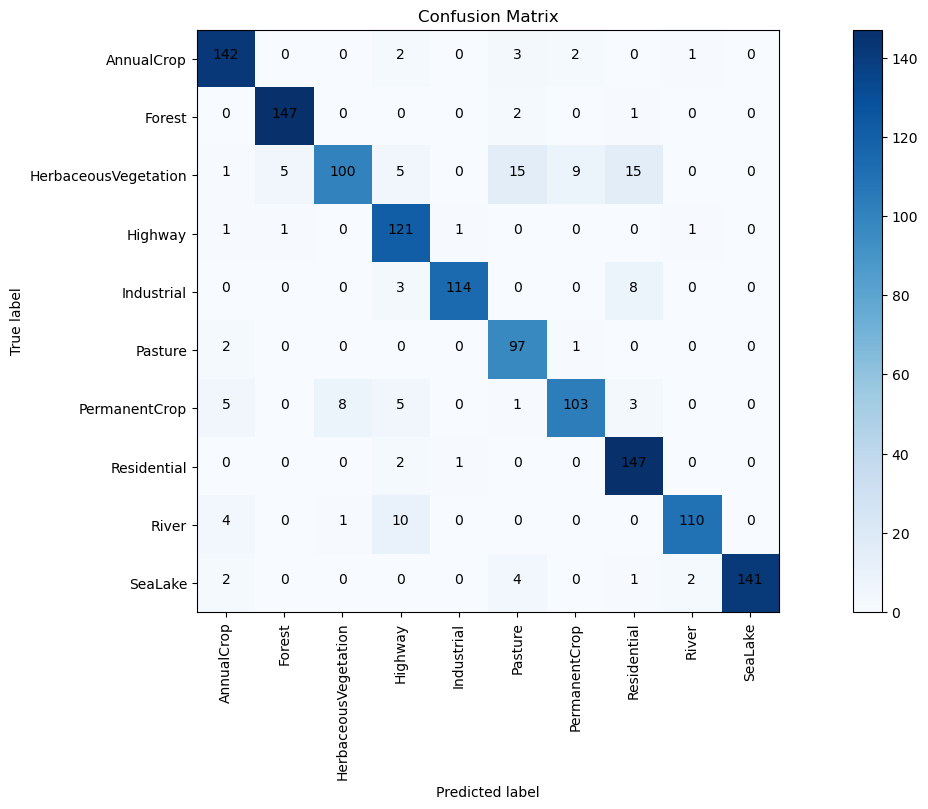

In [26]:
# Make predictions on the test data using the model
predictions = model.predict(test_batches, steps=270, verbose=0)

# confusion matrix using the results of the model on the test set
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
plot_confusion_matrix(cm, categories, title='Confusion Matrix')

In [27]:
# save trained model, including weights
model.save('land_use_model.keras')

# Viewing the Model Loss and Accuracy

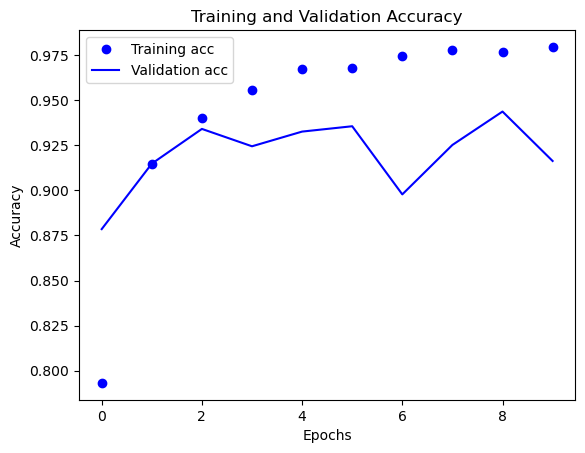

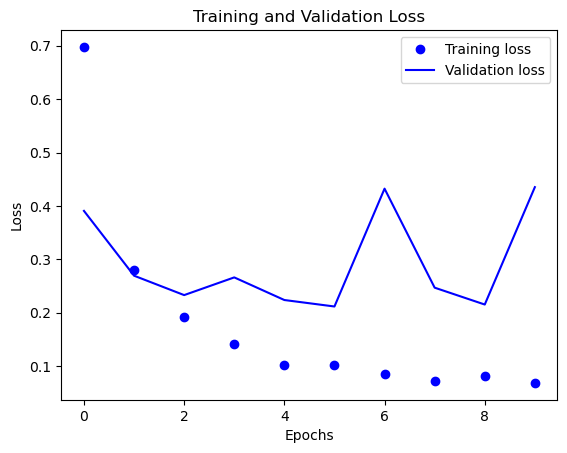

In [28]:
# Extract training and validation accuracy from the history object
acc = history.history['accuracy']  # List of training accuracies for each epoch
val_acc = history.history['val_accuracy']  # List of validation accuracies for each epoch

# Extract training and validation loss from the history object
loss = history.history['loss']  # List of training losses for each epoch
val_loss = history.history['val_loss']  # List of validation losses for each epoch

# Create a range object for the number of epochs
epochs = range(len(acc))  # The range object from 0 to the number of epochs

# Plot training and validation accuracy over epochs
plt.plot(epochs, acc, 'bo', label='Training acc')  # Plot training accuracy with blue dots
plt.plot(epochs, val_acc, 'b', label='Validation acc')  # Plot validation accuracy with a solid blue line
plt.title('Training and Validation Accuracy')  # Title of the accuracy plot
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.legend()  # Display the legend to differentiate between training and validation accuracy

# Create a new figure for the loss plot
plt.figure()

# Plot training and validation loss over epochs
plt.plot(epochs, loss, 'bo', label='Training loss')  # Plot training loss with blue dots
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # Plot validation loss with a solid blue line
plt.title('Training and Validation Loss')  # Title of the loss plot
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Loss')  # Y-axis label
plt.legend()  # Display the legend to differentiate between training and validation loss

# Display the plots
plt.show()  # Show the training and validation accuracy and loss plots

## Images at Intermediate Layers

Select a case:
1. Image from test_path
2. Image from dataset_path


Enter case number (1 or 2):  1
Enter the relative path to the image (e.g., /Residential/Residential_26.jpeg):  /Residential/Residential_26.jpeg


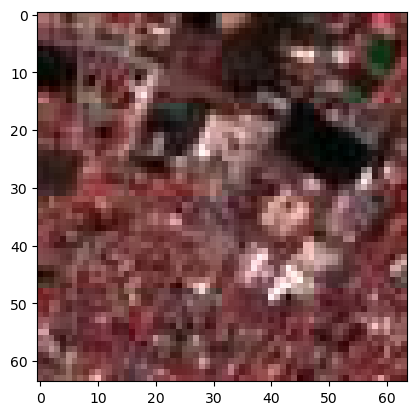

Image tensor shape: (1, 64, 64, 3)


In [32]:
flag = True
while flag:
    print("Select a case:")
    print("1. Image from test_path")
    print("2. Image from dataset_path")
    
    try:
        case = int(input("Enter case number (1 or 2): "))
    except ValueError:
        print("Invalid input. Please enter a number (1 or 2).")
        continue
    
    if case == 1:
        image_relative_path = input("Enter the relative path to the image (e.g., /Residential/Residential_26.jpeg): ")
        img_path = test_path + image_relative_path
        load_and_preprocess_image(img_path)
        flag = False  # Exit the loop after successful processing

    elif case == 2:
        image_relative_path = input("Enter the image name (e.g., /MelliehaCut.jpeg): ")
        img_path = dataset_path + '/converted-jpg-images' + image_relative_path
        load_and_preprocess_image(img_path)
        flag = False  # Exit the loop after successful processing

    else:
        print("Invalid case number. Please select either 1 or 2.")


In [33]:
def load_and_preprocess_image(img_path):
# Load and preprocess the image
    img = image.load_img(img_path, target_size=(64, 64))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.

    # Visualize the image
    plt.imshow(img_tensor[0])
    plt.show()

    # Ensure the shape matches the model's input requirements
    print("Image tensor shape:", img_tensor.shape) 

### Predicting and Displaying Class for Input Image

In [34]:
# Assuming `img` is your input image
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# Use model.predict to get probabilities for each class
predictions = model.predict(x, batch_size=10)

# Use np.argmax to get the index of the class with the highest probability
predicted_class_index = np.argmax(predictions, axis=1)[0]

print("Predicted class index is:", predicted_class_index)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Predicted class index is: 7


### Visualising Intermediate Activations

In [35]:
# Ensure the model is built by running it on some input data
_ = model.predict(np.zeros((1, 64, 64, 3)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


In [36]:
# Extract intermediate layer outputs
layer_outputs = [layer.output for layer in model.layers[:10]]  # Extracts the outputs of the top 10 layers

# Print each layer output details
for i, output in enumerate(layer_outputs):
    print(f"Layer {i+1} Output:")
    print(f"  Shape: {output.shape}")
    print(f"  Data Type: {output.dtype}")
    print(f"  Sparse: {output.sparse}")
    print(f"  Name: {output.name}")
    print()  # Print an empty line for separation

Layer 1 Output:
  Shape: (None, 64, 64, 64)
  Data Type: float32
  Sparse: False
  Name: keras_tensor_15

Layer 2 Output:
  Shape: (None, 64, 64, 64)
  Data Type: float32
  Sparse: False
  Name: keras_tensor_16

Layer 3 Output:
  Shape: (None, 32, 32, 64)
  Data Type: float32
  Sparse: False
  Name: keras_tensor_17

Layer 4 Output:
  Shape: (None, 32, 32, 128)
  Data Type: float32
  Sparse: False
  Name: keras_tensor_18

Layer 5 Output:
  Shape: (None, 32, 32, 128)
  Data Type: float32
  Sparse: False
  Name: keras_tensor_19

Layer 6 Output:
  Shape: (None, 16, 16, 128)
  Data Type: float32
  Sparse: False
  Name: keras_tensor_20

Layer 7 Output:
  Shape: (None, 16, 16, 256)
  Data Type: float32
  Sparse: False
  Name: keras_tensor_21

Layer 8 Output:
  Shape: (None, 16, 16, 256)
  Data Type: float32
  Sparse: False
  Name: keras_tensor_22

Layer 9 Output:
  Shape: (None, 16, 16, 256)
  Data Type: float32
  Sparse: False
  Name: keras_tensor_23

Layer 10 Output:
  Shape: (None, 8, 8, 2

In [37]:
# Create a new model that will return the outputs of the top 10 layers given the VGG16 input
activation_model = models.Model(inputs=vgg16_model.input, outputs=layer_outputs)

### Visualizing Activations of the First 10 Layers of VGG16

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step


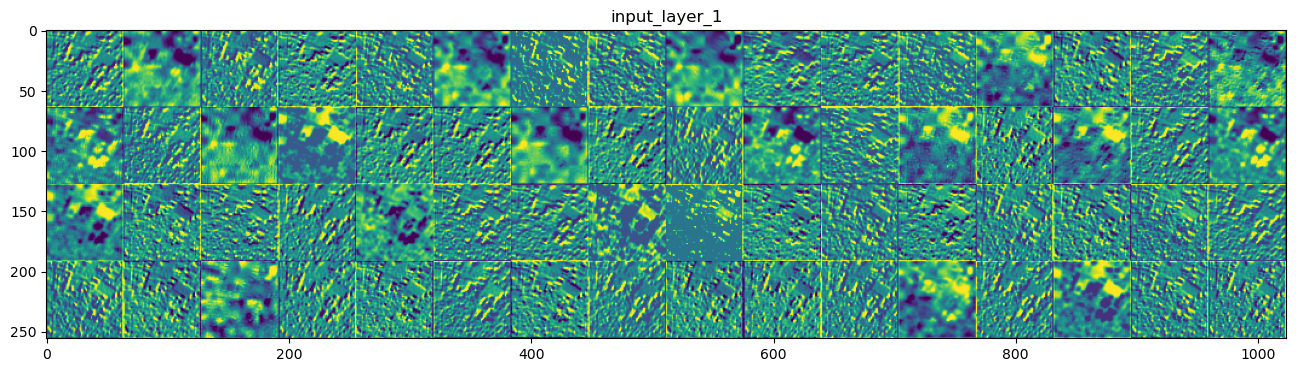

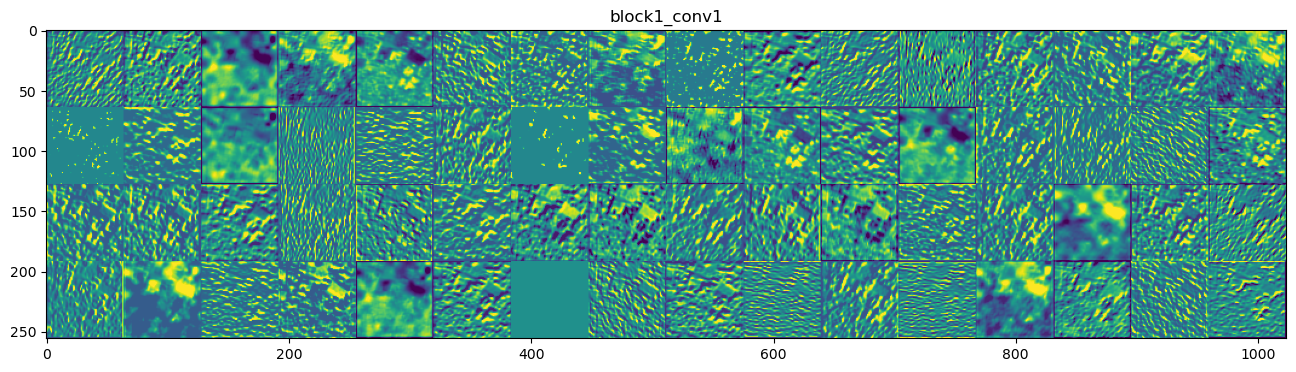

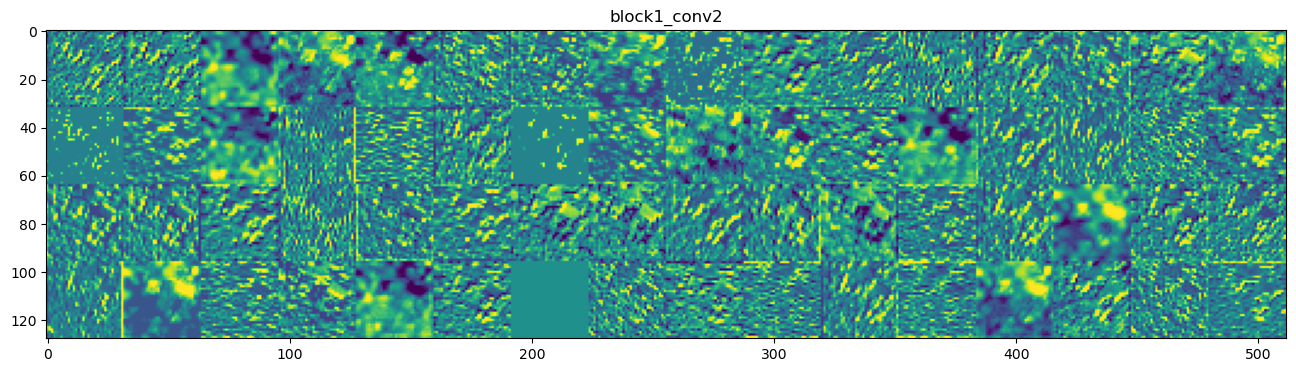

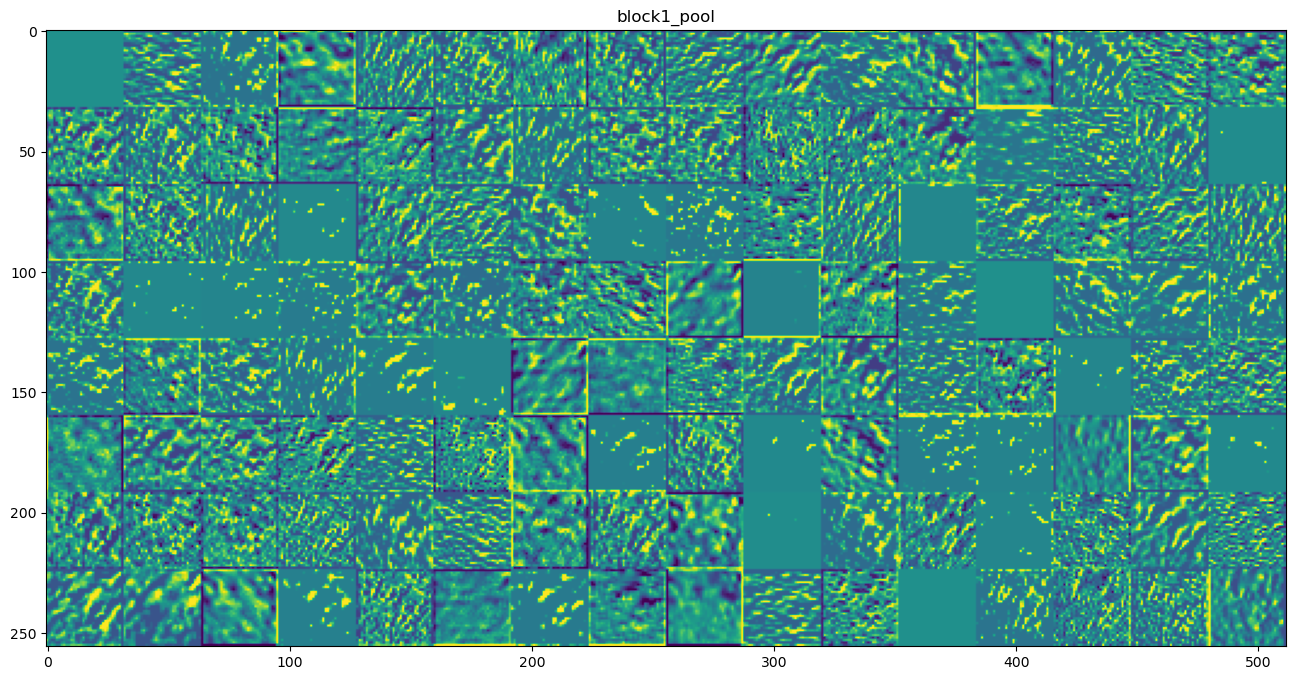

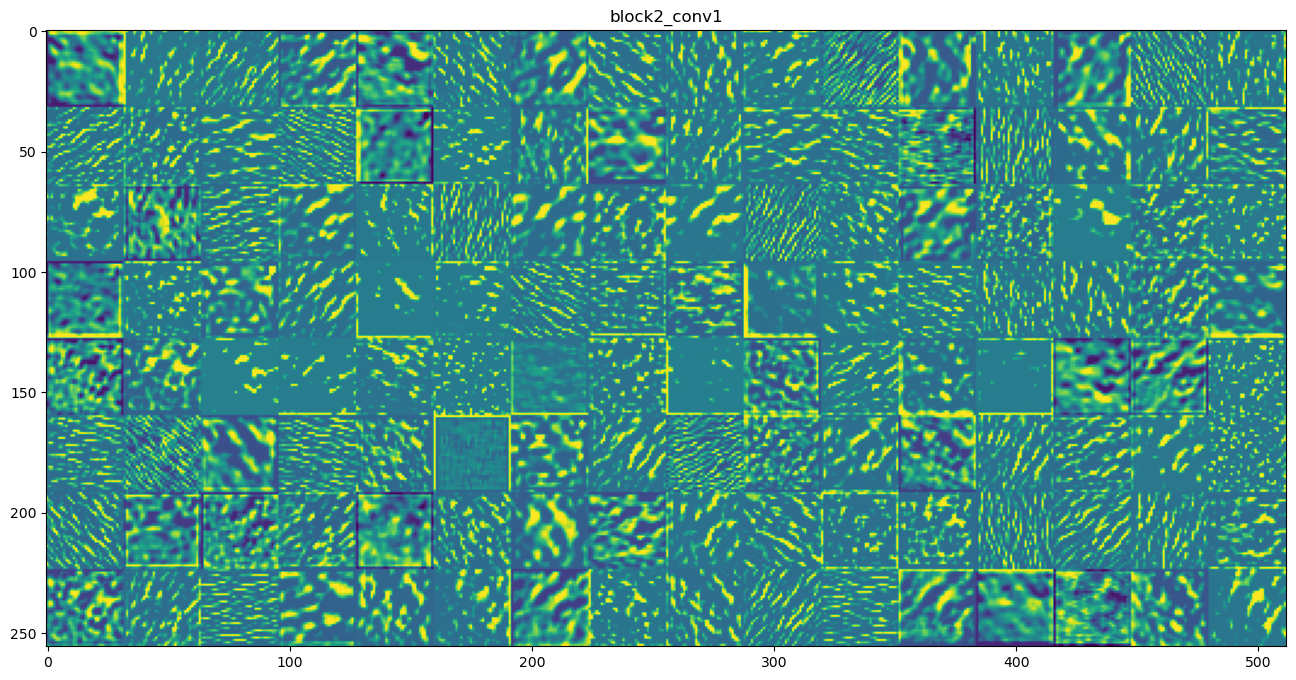

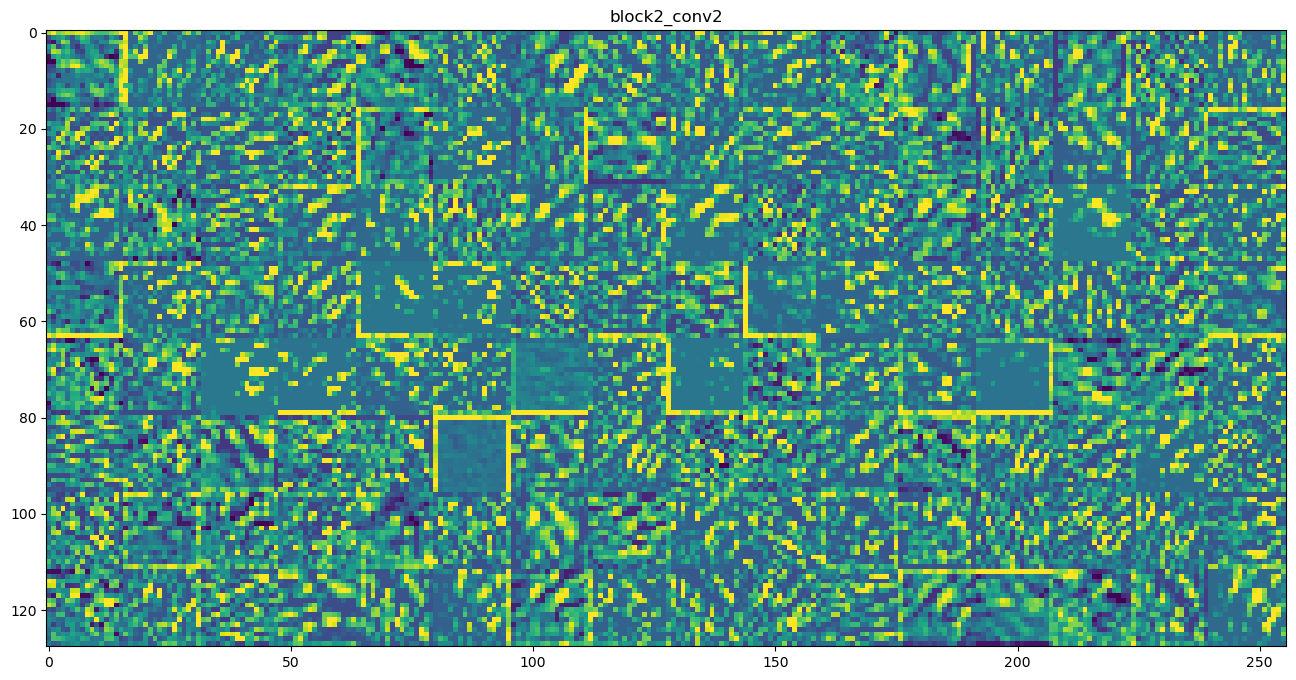

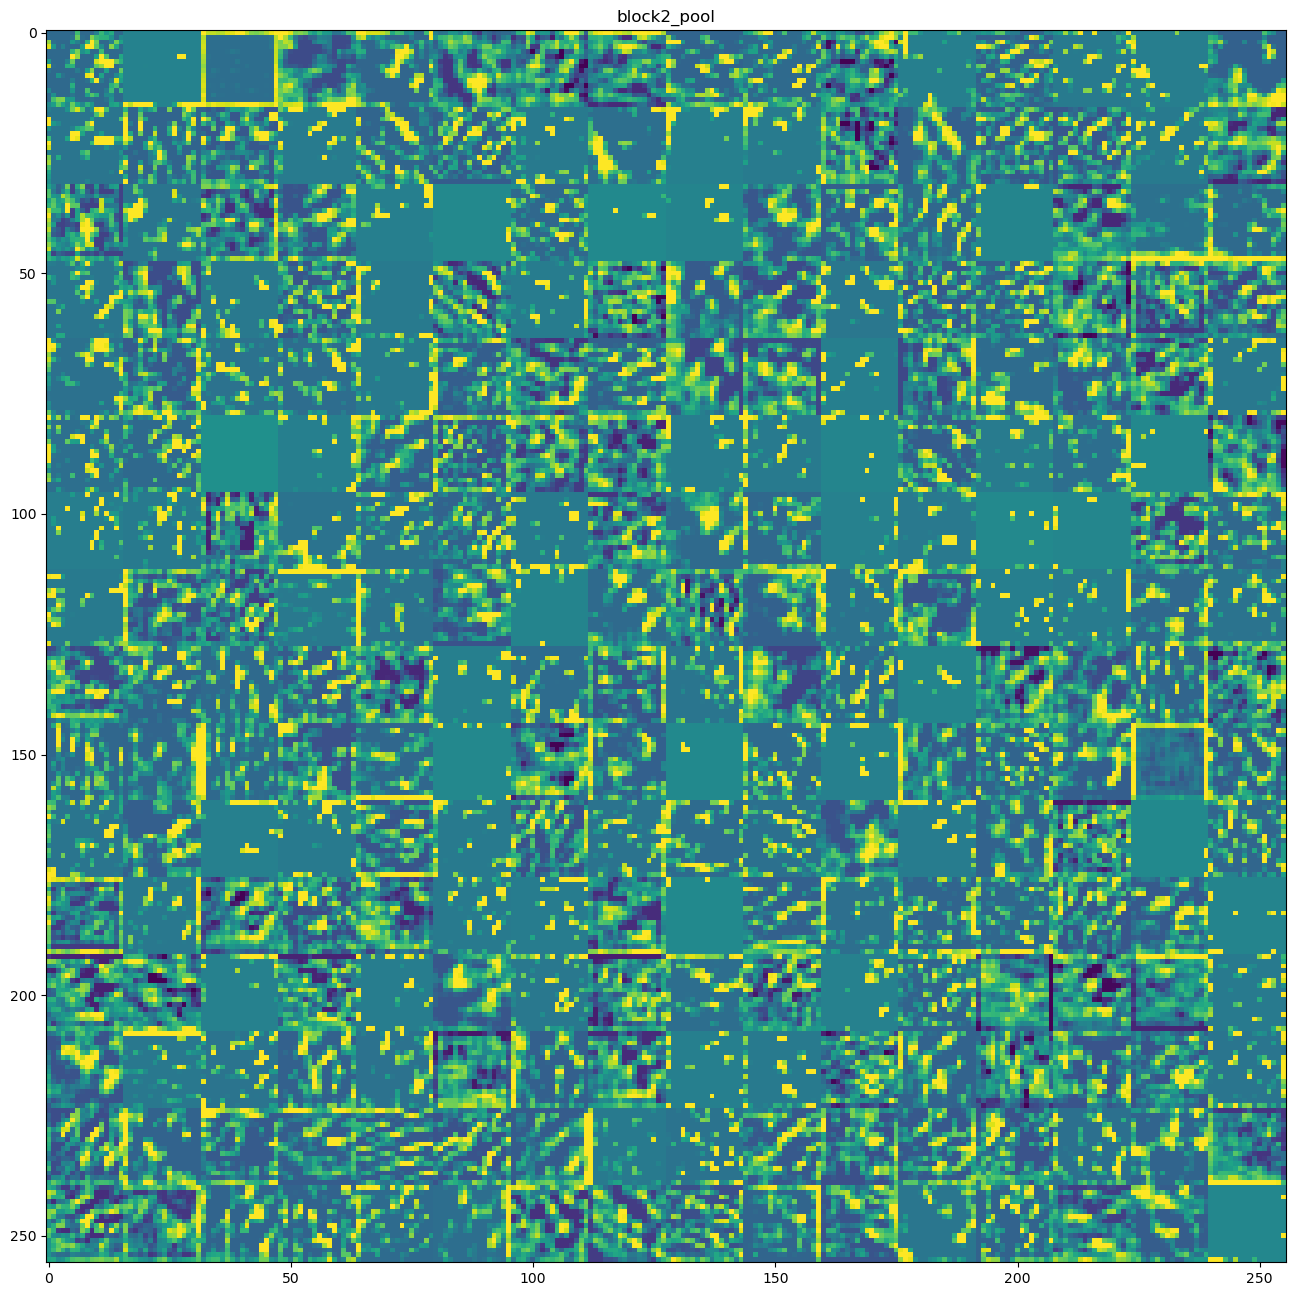

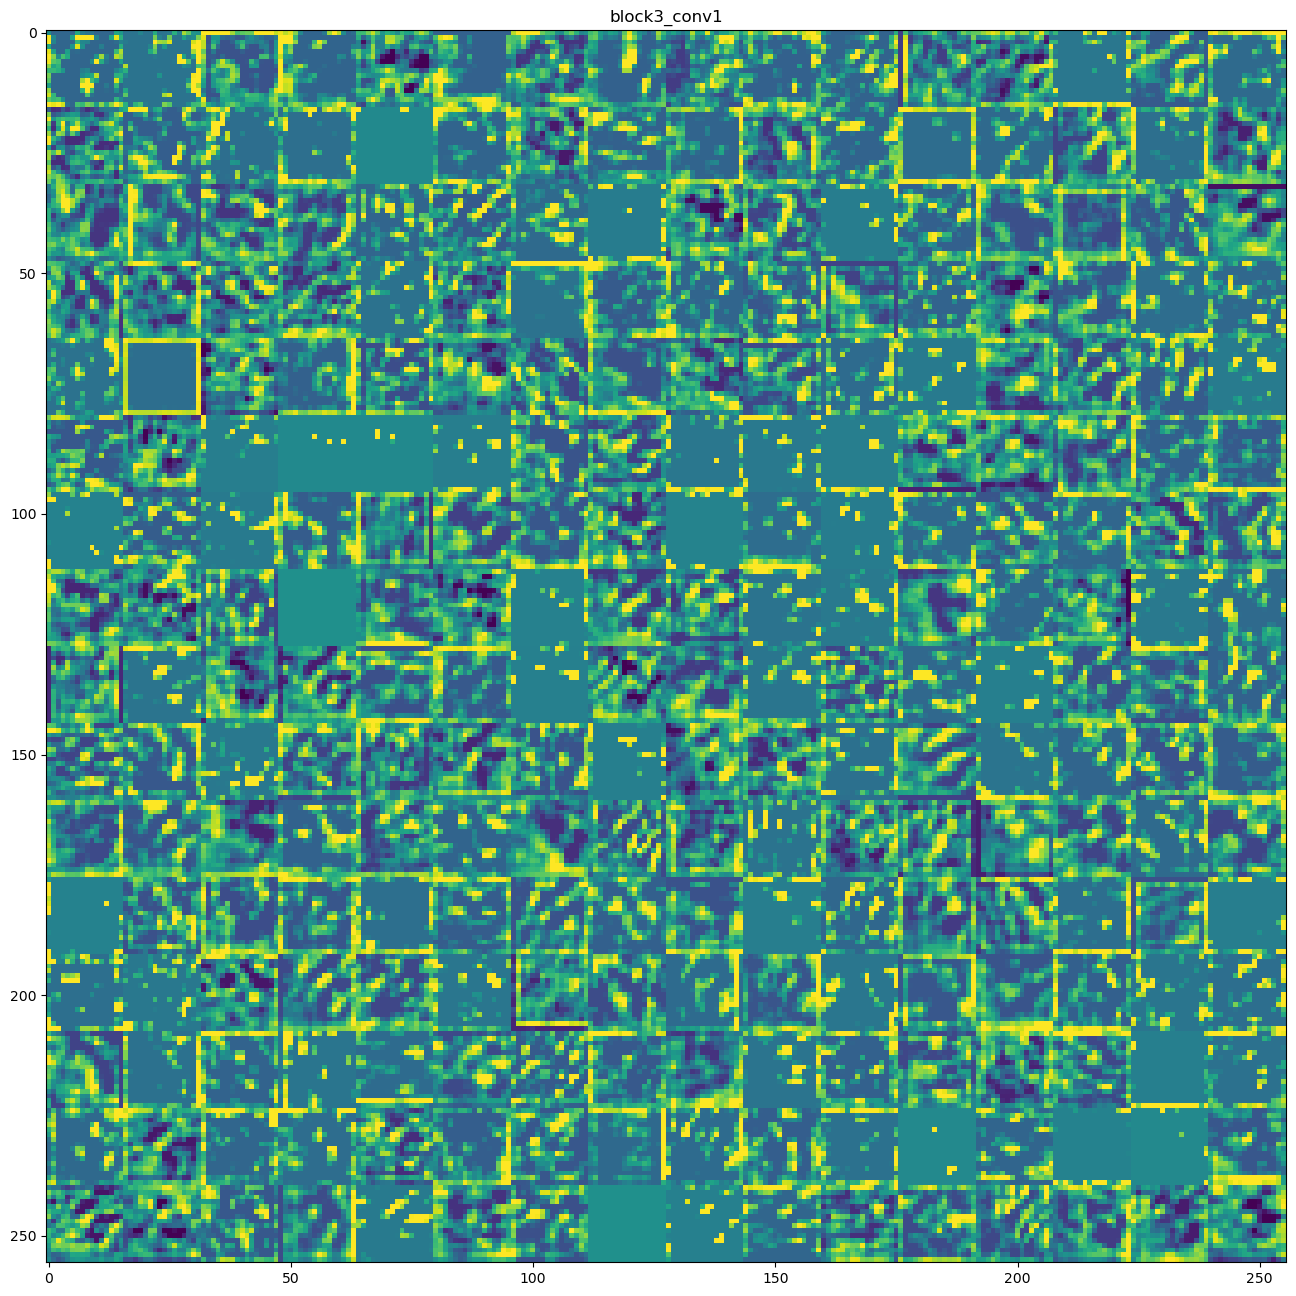

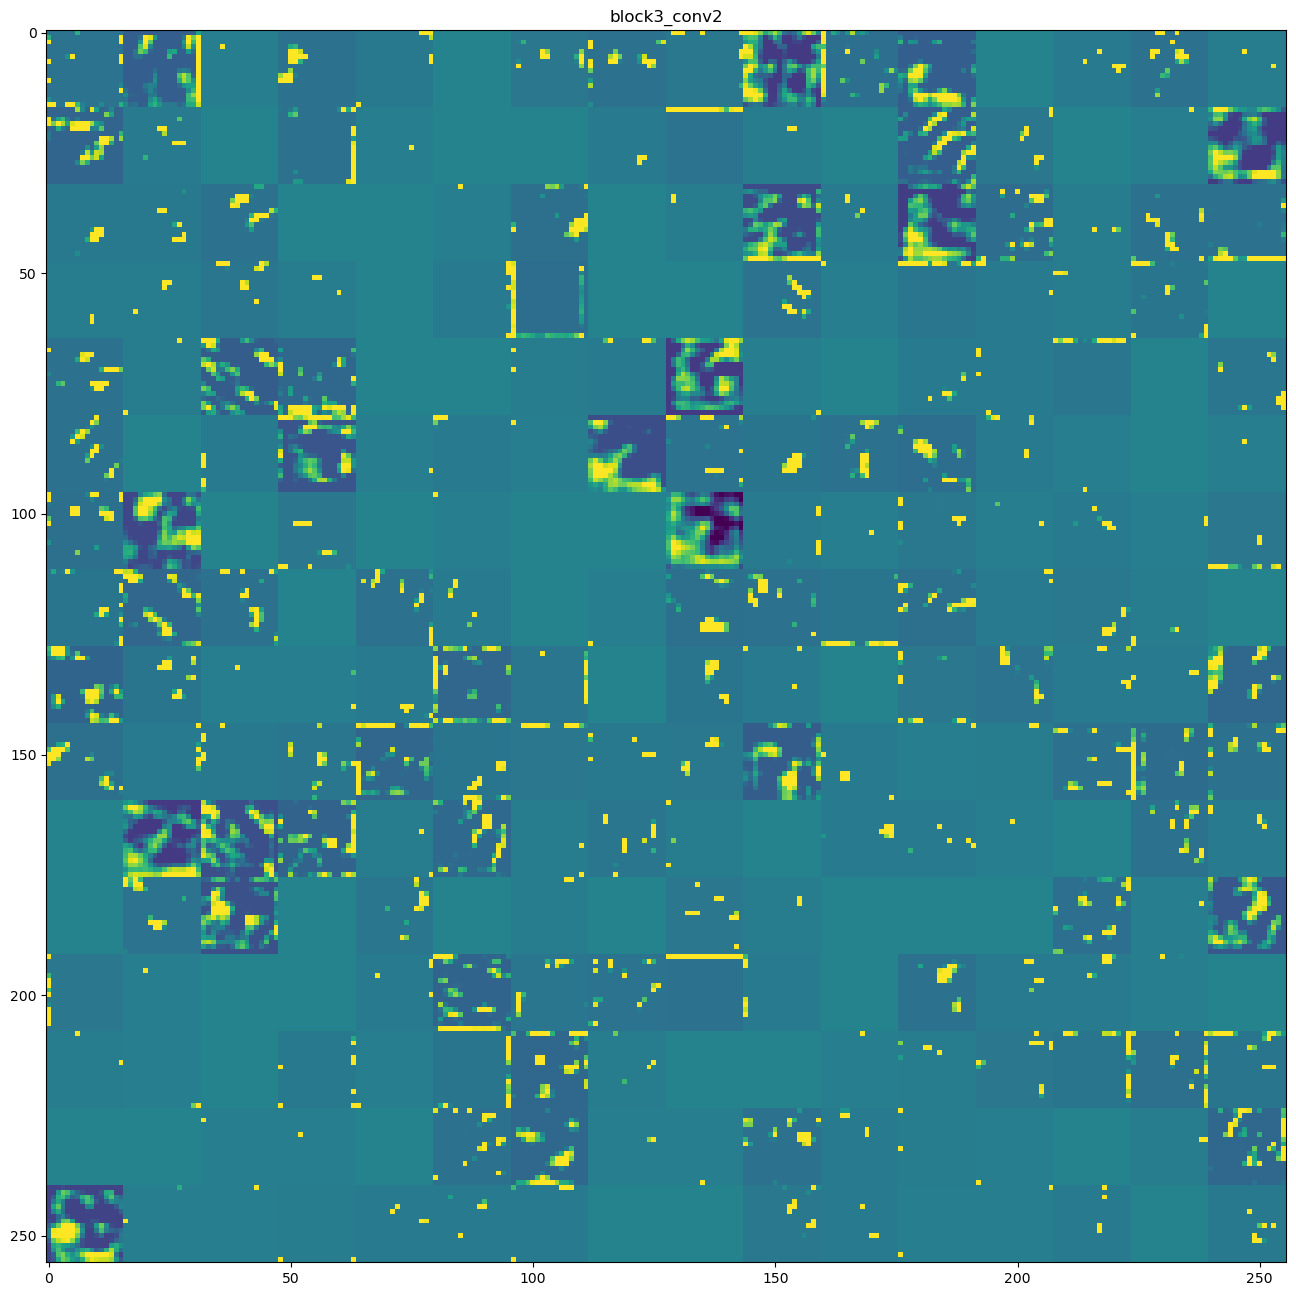

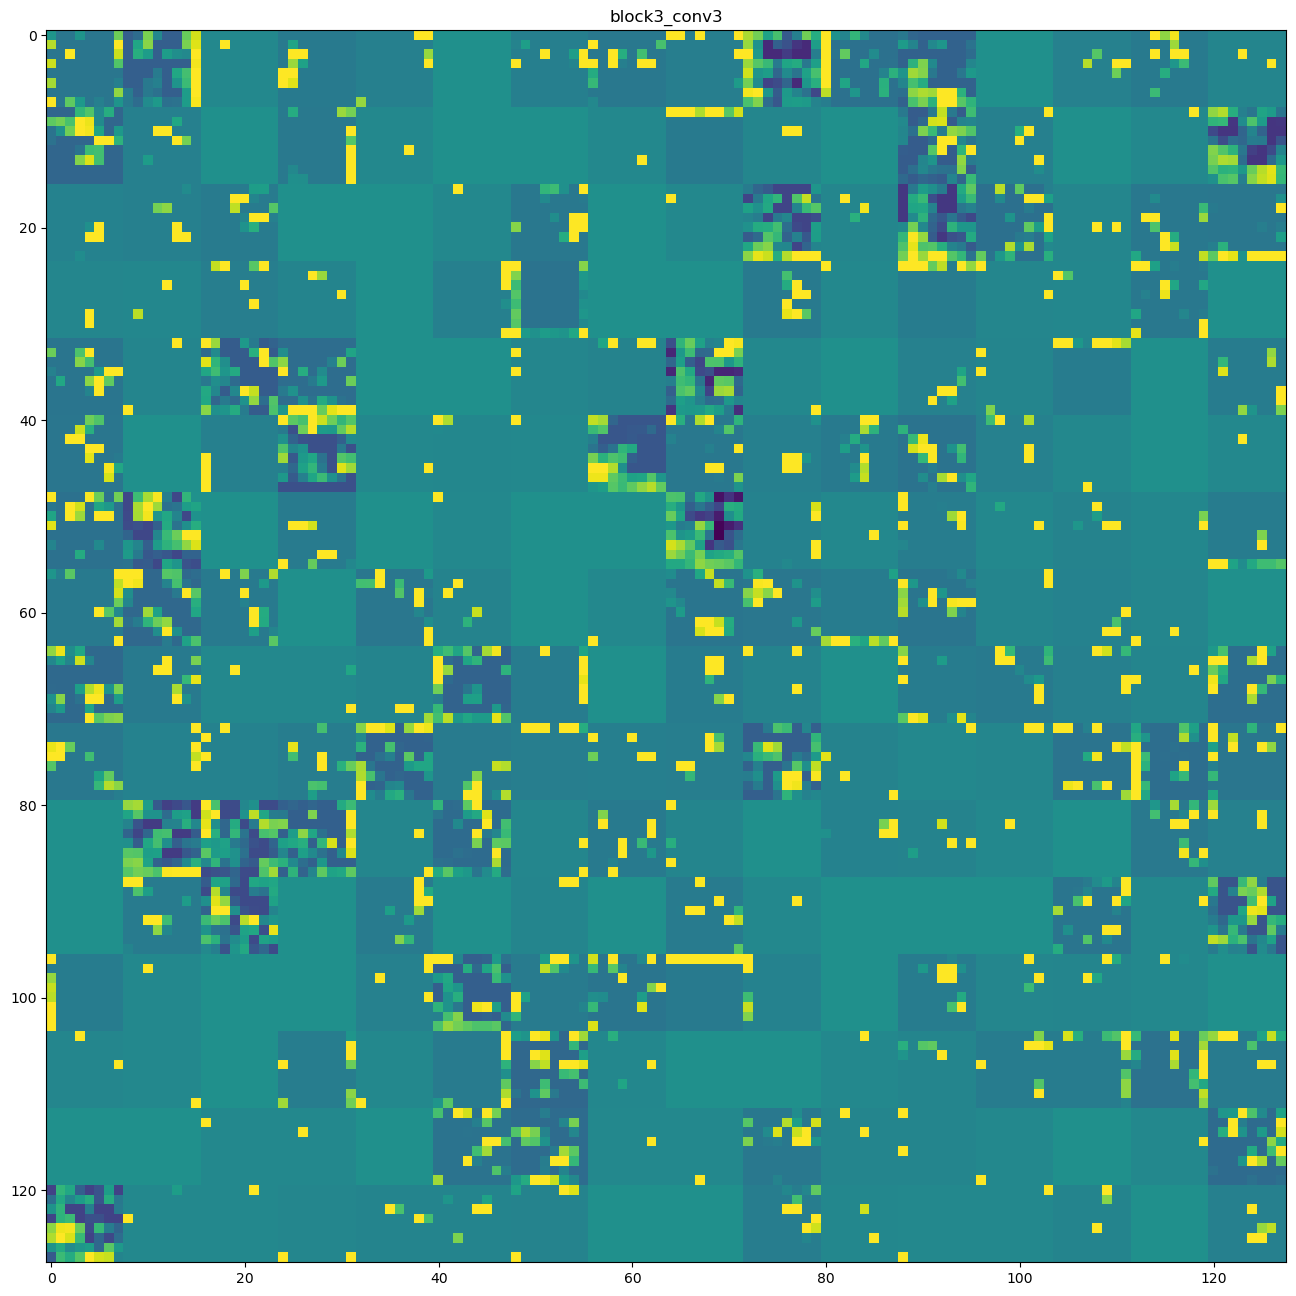

In [38]:
activations = activation_model.predict(img_tensor)

# Define layer names for plotting
# Extract the names of the first 10 layers from the VGG16 model to use as titles for the plots
layer_names = [layer.name for layer in vgg16_model.layers[:10]]

# Define how many images to display per row
images_per_row = 16  # Number of feature maps to display per row in the grid

# Display the activations
# Iterate through each layer and its corresponding activation tensor
for layer_name, layer_activation in zip(layer_names, activations):
    # `layer_activation` has the shape (1, size, size, n_features)
    n_features = layer_activation.shape[-1]  # Number of feature maps (channels) in the activation tensor
    size = layer_activation.shape[1]  # Size of each feature map (assuming square feature maps)
    n_cols = n_features // images_per_row  # Number of rows needed for the grid to display all feature maps
    
    # Initialize a blank grid to hold the feature maps
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    # Loop through each column of the grid
    for col in range(n_cols):  # Create a grid with `images_per_row` columns and `n_cols` rows
        # Loop through each row of the grid
        for row in range(images_per_row):
            # Extract the activation for the specific filter
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            # Normalize the feature map to have zero mean and unit variance
            channel_image -= channel_image.mean()  # Center the data around zero
            if channel_image.std() > 0:
                channel_image /= channel_image.std()  # Normalize the data to have unit variance
            # Enhance contrast for better visualization
            channel_image *= 64  # Scale the data
            channel_image += 128  # Offset the data
            # Clip the data to be in the range [0, 255] and convert to uint8 for display
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            # Place the image into the correct position in the grid
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    
    # Define the scale for the figure size based on the size of the feature maps
    scale = 1. / size
    # Create a new figure for the current layer
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)  # Set the title of the figure to the layer's name
    plt.grid(False)  # Disable the grid to make the feature maps clearer
    plt.imshow(display_grid, aspect='auto', cmap='viridis')  # Display the feature maps using the 'viridis' colormap

# Show all the figures
plt.show()

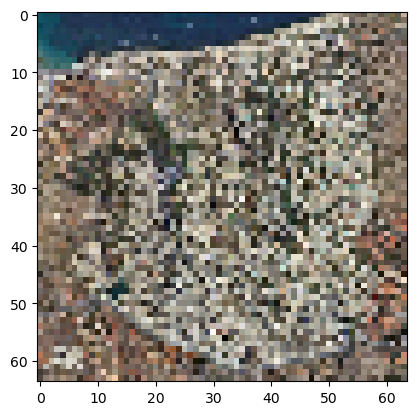

(1, 64, 64, 3)


In [39]:
img_path = dataset_path + '/converted-jpg-images/MelliehaCut.jpeg'

img = image.load_img(img_path, target_size=(64, 64))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

print(img_tensor.shape)

In [40]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# Use model.predict to get probabilities for each class
predictions = model.predict(x, batch_size=10)

# Use np.argmax to get the index of the class with the highest probability
predicted_class_index = np.argmax(predictions, axis=1)[0]

print("Predicted class index is:", predicted_class_index)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted class index is: 7


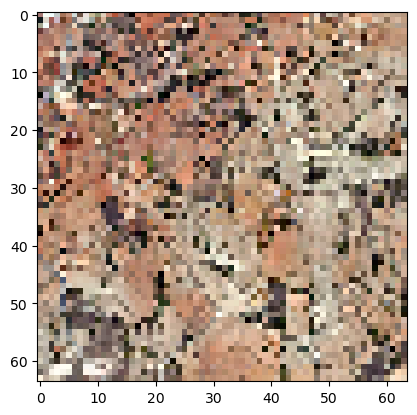

(1, 64, 64, 3)


In [41]:
img_path = dataset_path + '/converted-jpg-images/fields.jpeg'

img = image.load_img(img_path, target_size=(64, 64))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

print(img_tensor.shape)

In [42]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# Use model.predict to get probabilities for each class
predictions = model.predict(x, batch_size=10)

# Use np.argmax to get the index of the class with the highest probability
predicted_class_index = np.argmax(predictions, axis=1)[0]

print("Predicted class index is:", predicted_class_index)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted class index is: 7


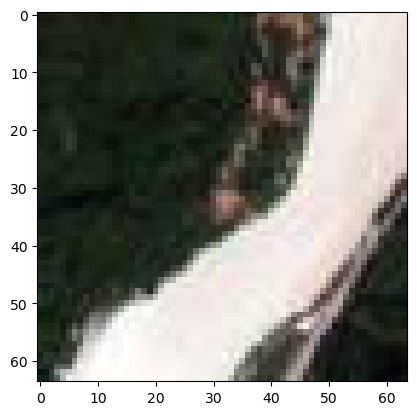

(1, 64, 64, 3)


In [43]:
img_path = test_path + '/River/River_26.jpeg'

img = image.load_img(img_path, target_size=(64, 64))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

print(img_tensor.shape)

In [44]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# Use model.predict to get probabilities for each class
predictions = model.predict(x, batch_size=10)

# Use np.argmax to get the index of the class with the highest probability
predicted_class_index = np.argmax(predictions, axis=1)[0]

print("Predicted class index is:", predicted_class_index)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted class index is: 8
